### Jupyter notebook for analyzing MSE profiles and related diagnostics for a given time step

James Ruppert, jruppert@ou.edu  
6/12/23

In [23]:
import numpy as np
from netCDF4 import Dataset,num2date
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
import os
import cartopy
import xarray as xr
from wrf import getvar, disable_xarray
from precip_class import precip_class
from thermo_functions import density_moist
from cfads_functions import mask_edges

In [2]:
# #### Main settings

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
memb_str = 'memb_01' # Which member to plot?

# Time step to plot
it_read = 4
# base time is adjusted by 36 for CTL, 0 for NCRF, etc.

In [3]:
# #### Directories

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/mse/"

# Tests to compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
# tests = ['crfon','ncrf']

if tests[1] == 'ncrf36h':
    t01=36
    t02=0
elif tests[1] == 'ncrf48h':
    t01=48
    t02=0
elif tests[1] == 'crfon':
    t01=0
    t02=48

t01+=it_read
t02+=it_read

In [33]:
testdir1 = main+storm+'/'+memb_str+'/'+tests[0]+'/'
testdir2 = main+storm+'/'+memb_str+'/'+tests[1]+'/'

# WRFOUT file list
dirlist = os.listdir(testdir1)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [testdir1 + s for s in wrf_files]
nwrf=len(wrf_files)
wrfout1 = wrf_files[t01]

dirlist = os.listdir(testdir2)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [testdir2 + s for s in wrf_files]
nwrf=len(wrf_files)
wrfout2 = wrf_files[t02]

ncfile = Dataset(wrfout1)
lat = ncfile.variables['XLAT'][0,:,0]
lon = ncfile.variables['XLONG'][0,0,:]
ni = ncfile.dimensions['west_east'].size
nj = ncfile.dimensions['south_north'].size
nz = ncfile.dimensions['bottom_top'].size
ncfile.close()
deg2m = np.pi*6371*1e3/180

# Address dateline issue
lonxx = np.copy(lon)
lonxx[(lon < 0)] += 360

x1d = lonxx * deg2m
y1d = lat * deg2m

In [34]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

def get_lon_offset_plt():
    # Check for crossing Date Line
    if (lon.min() < 0) and (lon.max() > 0):
        offset = 180
        lon_offset = dateline_lon_shift(lon, reverse=0)
    else:
        offset = 0
        lon_offset = 0
        clon_offset = 0
    lon_offset_plt = lon + lon_offset
    lon_offset_plt -= offset
    return offset, lon_offset_plt

offset, lon_offset_plt = get_lon_offset_plt()

### Read variables and conduct classification
---

In [7]:
# Read function
def var_read(infile, varname):
    ncfile = Dataset(infile)
    var = ncfile.variables[varname][...]
    ncfile.close()
    var = np.squeeze(var)
    var = mask_edges(var)
    return var

def var_wrfread(infile, varname):
    disable_xarray()
    ncfile = Dataset(infile)
    var = getvar(ncfile, varname)
    ncfile.close()
    var = np.squeeze(var)
    var = mask_edges(var)
    return var

def qvar_read(infile, dp):
    # Read in and vertically integrate mixing ratios
    q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
    g = 9.81 # m/s^2
    nvar = len(q_list)
    q_var = []
    for ivar in range(nvar):
        ivar = var_read(infile,q_list[ivar]) # kg/kg
        q_var.append(ivar)
    q_var = np.stack(q_var, axis=0)
    q_int = np.sum(q_var*dp, axis=1)/(-g)
    return q_var, q_int

In [8]:
def read_ctype_og(testdir, it_read):
    # Traditional classification scheme
    #   Fortran code to calculate this from same model output courtesy of
    #   Rosi Rios-Berrios (NCAR), who wrote it based on Rogers (2010, JAS)
    pclass_trad = testdir+'post/d02/strat.nc'
    varfil_main = Dataset(pclass_trad)
    c_type_og = varfil_main.variables['strat'][it_read,...]
    varfil_main.close()
    c_type_og = np.squeeze(c_type_og)
    c_type_og = mask_edges(c_type_og)
    #  0: non-precipitating
    #  1: convective
    #  2: stratiform
    #  3: "other" (assumed to be anvil)
    return c_type_og

In [9]:
def class_variables(wrffile):

    # Read in hydrostatic pressure to get dp for integral
    p_hyd = var_read(wrffile,'P_HYD') # Pa
    # p_hyd = np.ma.masked_where((p_hyd < 100e2), p_hyd, copy=False) # Mask out levels above 100 hPa
    dp = np.gradient(p_hyd, axis=0, edge_order=1) # [Pa] Uses second order centered differencing

    # Run new classification
    q_var, q_int = qvar_read(wrffile, dp)
    c_type = precip_class(q_int)
    c_type = mask_edges(c_type)
    #   0: non-precipitating
    # Convective:
    #   1: deep convective
    #   2: congestus
    #   3: shallow
    # Layered:
    #   4: stratiform
    #   5: anvil (weaker rainfall)

    return p_hyd, dp, q_var, c_type

In [10]:
def misc_variables(wrffile):
    # Various necessary vars
    varname='wa' # Vertical motion [m/s]
    w = var_wrfread(wrffile,varname) # wrf.getvar interpolates onto mass grid
    varname='ua' # Zonal motion [m/s]
    u = var_wrfread(wrffile,varname) # wrf.getvar interpolates onto mass grid
    varname='va' # Meridional motion [m/s]
    v = var_wrfread(wrffile,varname) # wrf.getvar interpolates onto mass grid
    varname='tk'
    tmpk = var_wrfread(wrffile,varname) # Temperature [K]; wrf.getvar adds base state
    varname='QVAPOR'
    qv = var_read(wrffile,varname) # Water vapor mixing ratio [kg/kg]
    varname='pres' # Pressure [hPa]
    pres = var_wrfread(wrffile,varname) # wrf.getvar interpolates onto mass grid
    rho = density_moist(tmpk, qv, pres)
    return w, u, v, tmpk, qv, rho

In [11]:
def rad_tend(wrffile):

    # Radiative tendencies [K/s]
    varname='RTHRATLW'
    lw = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATLWC'
    lwc = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATSW'
    sw = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATSWC'
    swc = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    crf = sw + lw - lwc - swc

    # Vertically integrated radiative terms
    lw_t = var_read(wrffile,'LWUPT') - var_read(wrffile,'LWDNT') # W/m2
    lw_b = var_read(wrffile,'LWUPB') - var_read(wrffile,'LWDNB') # W/m2
    lw_net = lw_b - lw_t
    # Clear sky
    lw_tc = var_read(wrffile,'LWUPTC') - var_read(wrffile,'LWDNTC') # W/m2
    lw_bc = var_read(wrffile,'LWUPBC') - var_read(wrffile,'LWDNBC') # W/m2 = J/m2/s
    lw_net_cs = lw_bc - lw_tc
    acre = lw_net - lw_net_cs

    return crf, lw_net, lw_net_cs

In [12]:
# Dry and moist static energy (DSE, MSE), J/kg
def static_energies(wrffile, tmpk, qv):

    # Various necessary vars
    varname='geopt'
    ph = var_wrfread(wrffile,varname) # Geopotential = g*z; wrf.getvar interpolates onto mass grid

    # ;LATENT HEAT OF VAPORIZATION
    cp=1004.  # J/K/kg
    cpl=4186. # J/k/kg
    cpv=1885. # J/K/kg
    lv0=2.5e6 # J/kg
    lv = lv0 - (cpl-cpv)*(tmpk-273.15)

    # Dry static energy (DSE)
    dse_z = cp*tmpk + ph
    # Moist static energy (MSE)
    mse_z = dse_z + lv*qv

    return dse_z, mse_z

In [13]:
def mse_variance(mse, lw_net, lw_net_cs):

    # MSE variance terms

    # Remove means
    mse_mean = np.mean(mse)
    mse_p = mse - mse_mean
    lw_mean = np.mean(lw_net)
    lw_p = lw_net - lw_mean
    lw_mean_cs = np.mean(lw_net_cs)
    lw_p_cs = lw_net_cs - lw_mean_cs

    # Calculate covariance
    lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
    msevar = np.var(mse) # (J/m2)^2
    lwmse /= msevar # units = /s
    lwmse *= 3600*24 # /s --> /day

    # Clear-sky
    lwmse_cs = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
    lwmse_cs /= msevar # units = /s
    lwmse_cs *= 3600*24 # s/day * /s = /day

    return lwmse, lwmse_cs

In [14]:
def vertical_int(var, dp):
    g=9.81 # m/s^2
    return np.sum(var*dp, axis=0)/(-g)

In [15]:
# Run first test

p_hyd, dp, q_var, c_type = class_variables(wrfout1)
c_type_og = read_ctype_og(testdir1, t01)
w, u, v, tmpk, qv, rho = misc_variables(wrfout1)
crf, lw_net, lw_net_cs = rad_tend(wrfout1)
dse_z, mse_z = static_energies(wrfout1, tmpk, qv)
dse = vertical_int(dse_z, dp)
mse = vertical_int(mse_z, dp)
lwmse, lwmse_cs = mse_variance(mse, lw_net, lw_net_cs)

In [16]:
# Run second test

p_hyd2, dp2, q_var2, c_type2 = class_variables(wrfout2)
c_type_og2 = read_ctype_og(testdir2, t02)
w2, u2, v2, tmpk2, qv2, rho2 = misc_variables(wrfout2)
crf2, lw_net2, lw_net_cs2 = rad_tend(wrfout2)
dse_z2, mse_z2 = static_energies(wrfout2, tmpk2, qv2)
dse2 = vertical_int(dse_z2, dp2)
mse2 = vertical_int(mse_z2, dp2)
lwmse2, lwmse_cs2 = mse_variance(mse2, lw_net2, lw_net_cs2)

## Plot results
---

In [17]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Maps of MSE-LW variance masked by class

In [26]:
lon_offset_plt

masked_array(data=[144.02167, 144.05283, 144.08398, ..., 181.31815,
                   181.3493 , 181.38046],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

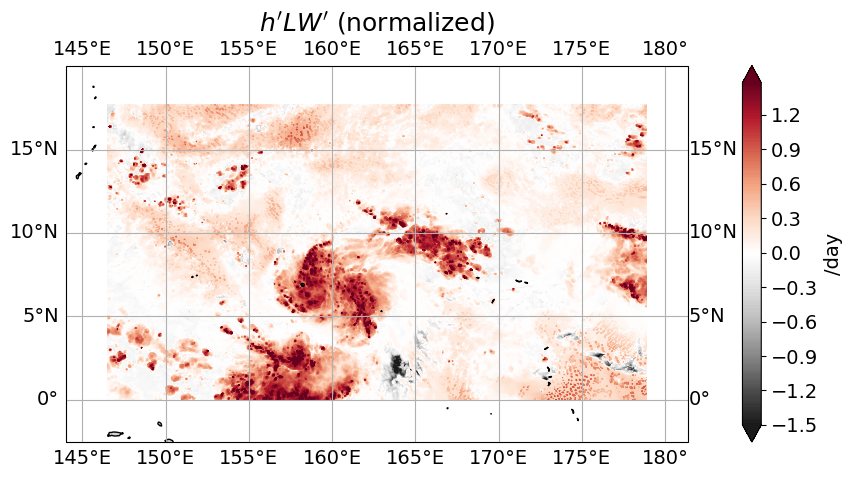

In [41]:
# Unmasked

# LWMSE term
pltvar = lwmse
title = "$h'LW'$ (normalized)"
units = '/day'
clevs = np.arange(-1.5,1.5,0.02)

# ACRE
# pltvar = lw_net - lw_net_cs
# title = "ACRE"
# units = 'W/m$^2$'
# clevs = np.arange(-50,200,5)

fig = plt.figure(figsize=(12,5))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
fig.set_facecolor('white')

ax = fig.add_subplot(111,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.05)
cbar.set_label(units)
ax.set_title(title, size=18)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
plt.tight_layout()

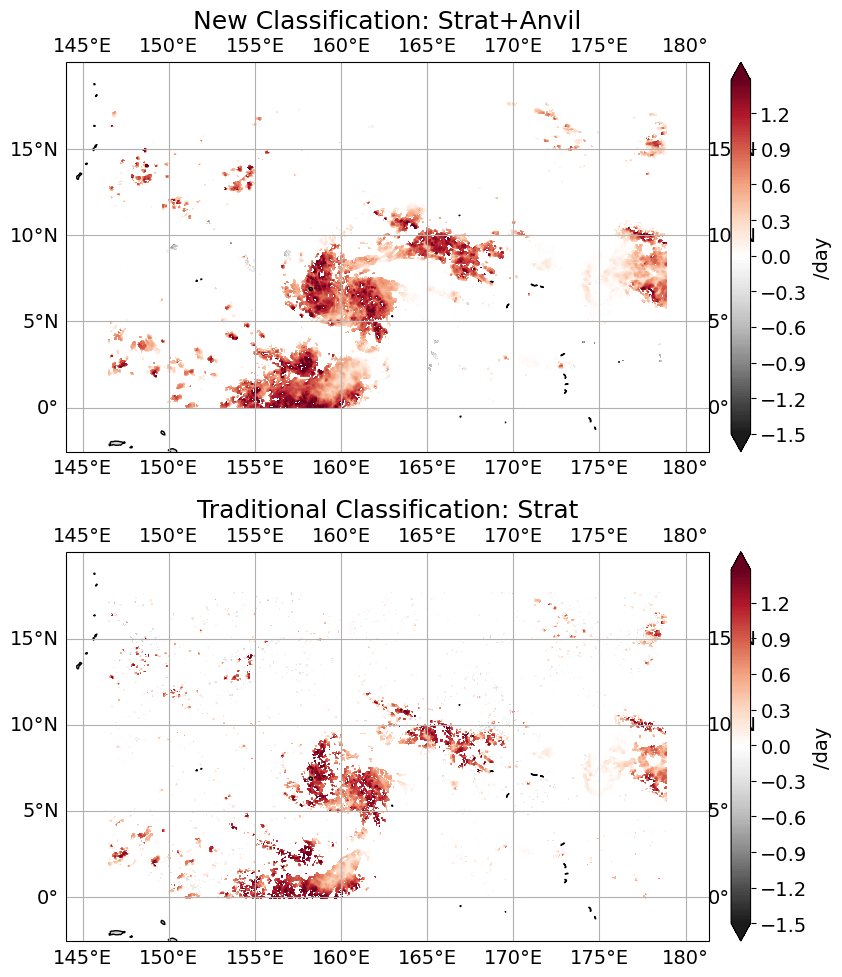

In [39]:
# Stratiform

fig = plt.figure(figsize=(12,10))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
fig.set_facecolor('white')

# New classification
pltvar_mask = np.ma.masked_where((c_type < 4), pltvar, copy=True)
ax = fig.add_subplot(211,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label(units)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
ax.set_title("New Classification: Strat+Anvil", size=18)

# Traditional classification
pltvar_mask = np.ma.masked_where((c_type_og < 2), pltvar, copy=True)
ax = fig.add_subplot(212,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label(units)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
ax.set_title("Traditional Classification: Strat", size=18)

plt.tight_layout()

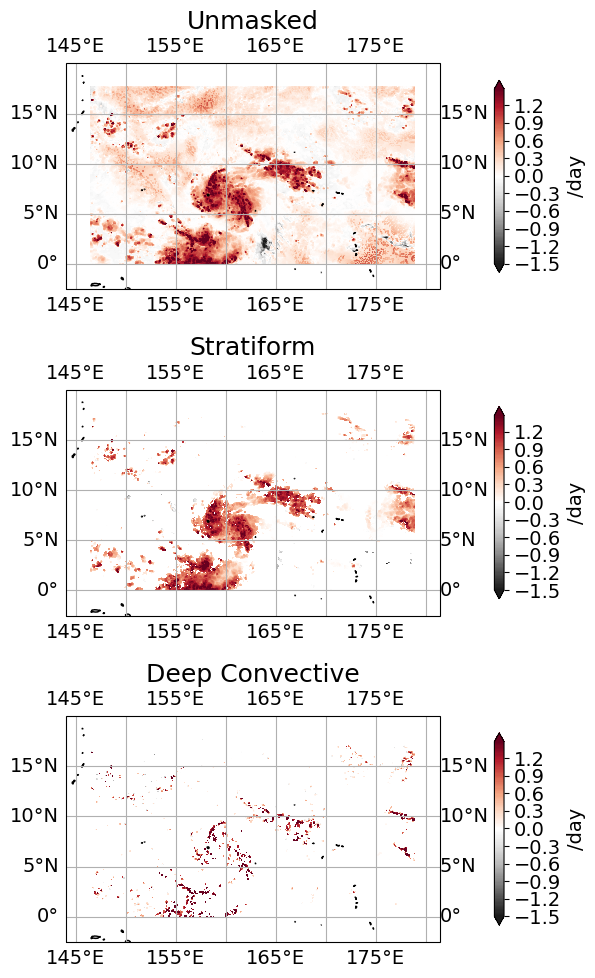

In [44]:
# Unmaked, Strat, Deep conv

fig = plt.figure(figsize=(12,10))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
fig.set_facecolor('white')

# Unmasked
pltvar = lwmse
ax = fig.add_subplot(311,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(shrink=0.85, fraction=0.03, pad=0.05)
cbar.set_label(units)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
ax.set_title("Unmasked", size=18)

# Stratiform
pltvar_mask = np.ma.masked_where((c_type < 4), pltvar, copy=True)
ax = fig.add_subplot(312,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(shrink=0.85, fraction=0.03, pad=0.05)
cbar.set_label(units)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
ax.set_title("Stratiform", size=18)

# Deep Conv
pltvar_mask = np.ma.masked_where((c_type != 1), pltvar, copy=True)
ax = fig.add_subplot(313,projection=proj)
plt.contourf(lon_offset_plt, lat, pltvar_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(shrink=0.85, fraction=0.03, pad=0.05)
cbar.set_label(units)
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)
ax.set_title("Deep Convective", size=18)

plt.tight_layout()

### Vertical profiles
---

In [105]:
# Use mean p_hyd as vertical coordinate
pres = np.mean(p_hyd, axis=(1,2))*1e-2 # Pa --> hPa
pres2 = np.mean(p_hyd2, axis=(1,2))*1e-2 # Pa --> hPa

In [106]:
# Function to plot class-averaged profiles
def plot_profiles_class(var_profile, precip_list, var_conv, var_strat, var_profile_og, xlabel, pres,
                        zeroline=True):
    
    fig = plt.figure(figsize=(12,8),facecolor='white')

    # Profile 1
    ax = fig.add_subplot(121)
    ax.plot(var_profile[0], pres, label=precip_list[0], color='blue')
    ax.plot(var_profile[1], pres, label=precip_list[1], color='red')
    ax.plot(var_profile[2], pres, label=precip_list[2], color='green')
    ax.plot(var_conv, pres, label='All', linestyle='--', color='black')
    ax.plot(var_profile_og[0], pres, label='Traditional', color='black')
    ax.set_title('Convective', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

    # Profile 2
    ax = fig.add_subplot(122)
    ax.plot(var_profile[3], pres, label=precip_list[3], color='blue')
    ax.plot(var_profile[4], pres, label=precip_list[4], color='red')
    ax.plot(var_strat, pres, label='All', linestyle='--', color='black')
    ax.plot(var_profile_og[1], pres, label='Traditional', color='black')
    ax.set_title('Stratiform', size=16, weight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    plt.ylim(1000,100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [107]:
# Function to get class-averaged profiles
def var_profiles_class(var, c_type, c_type_og, pres, xlabel, zeroline=True):
    
    # New classification scheme
    precip_list = ['Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    n_class = len(precip_list)
    nzloc=var.shape[0]
    var_profile = np.ma.empty((n_class,nzloc))
    for t in range(n_class):
        ind = (c_type == t+1).nonzero()
        var_profile[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)
    
    ind = ((c_type > 0) & (c_type < 4)).nonzero()
    var_conv = np.ma.mean(var[:,ind[0],ind[1]], axis=1) # convective total
    ind = (c_type > 3).nonzero()
    var_strat = np.ma.mean(var[:,ind[0],ind[1]], axis=1) # stratiform total

    # Traditional classification scheme
    precip_list_og = ['conv', 'strat', 'mixed']
    n_class_og = len(precip_list_og)
    var_profile_og = np.ma.empty((n_class_og,nzloc))
    for t in range(n_class_og):
        ind = (c_type_og == t+1).nonzero()
        var_profile_og[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)
    
    plot_profiles_class(var_profile, precip_list, var_conv, var_strat, var_profile_og, xlabel, pres,
                        zeroline)

#### Average w-profiles

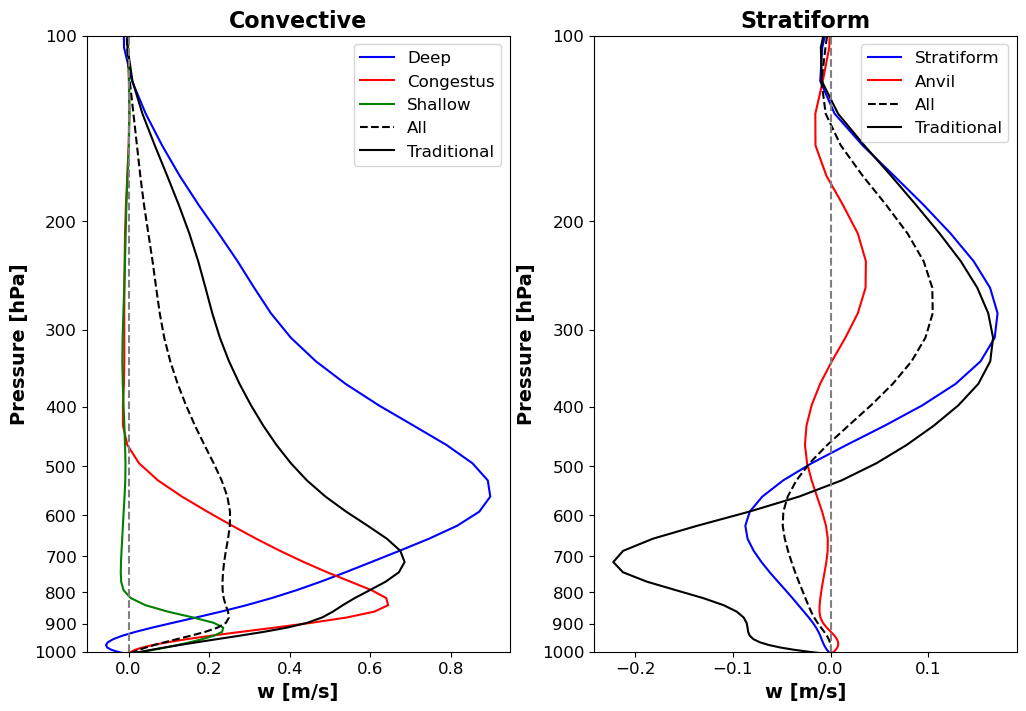

In [108]:
# w profile
var = np.copy(w)
xlabel = 'w [m/s]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

#### Average MSE profiles

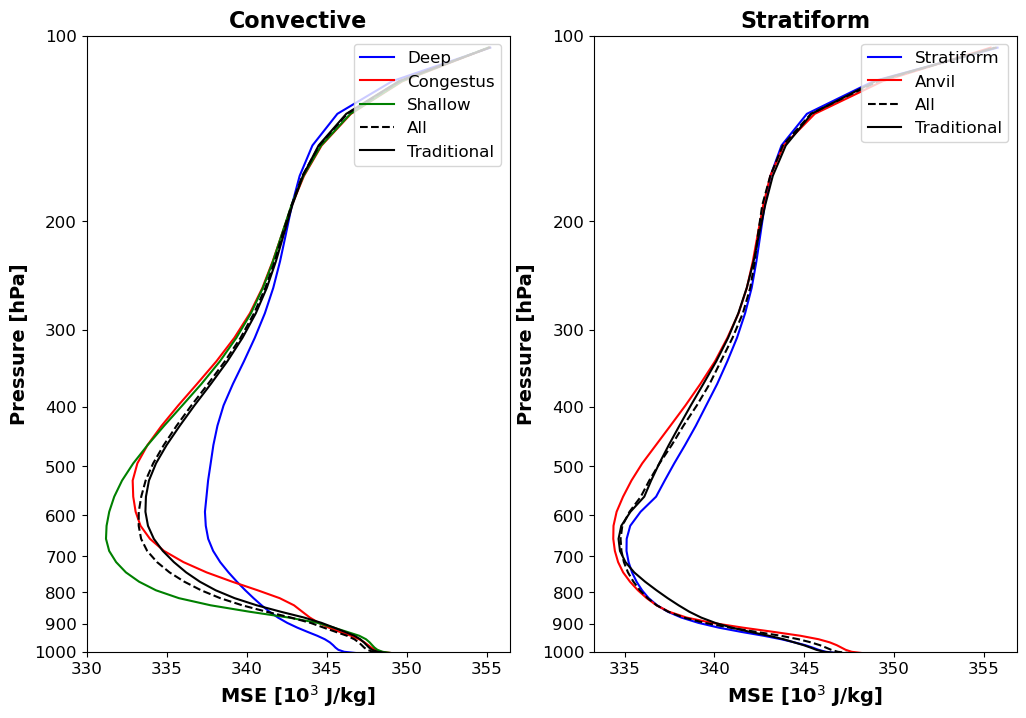

In [109]:
var = np.copy(mse_z)*1e-3
xlabel = 'MSE [10$^3$ J/kg]'
iptop = np.where(pres <= 100)[0][0]
var_profiles_class(var[:iptop], c_type, c_type_og, pres[:iptop], xlabel, zeroline=False)

#### Average DSE profiles

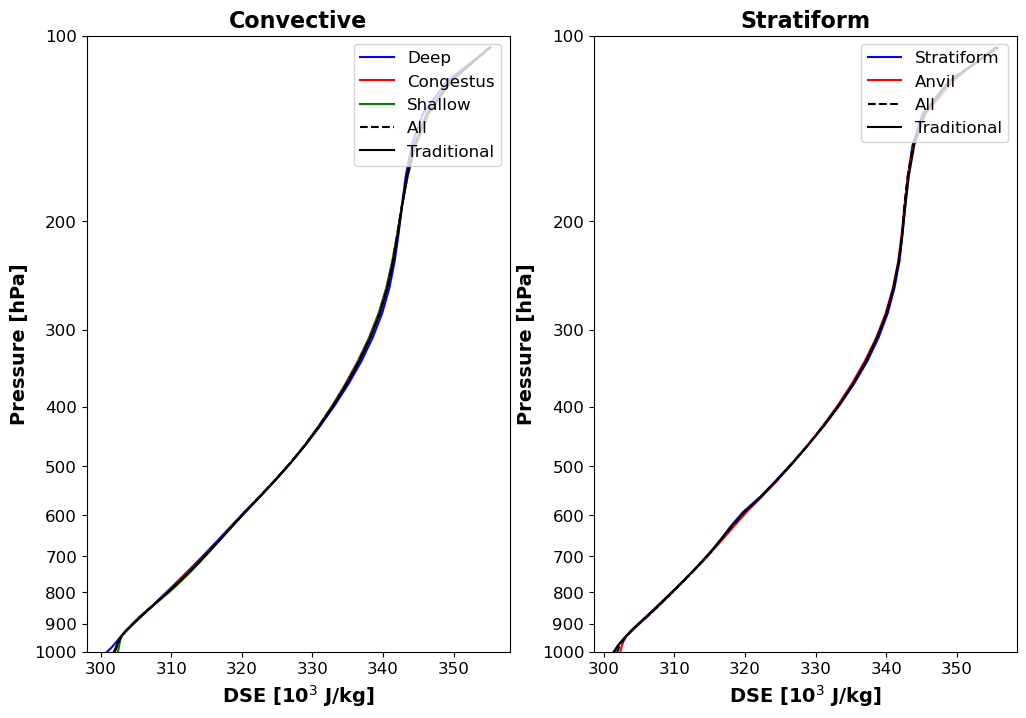

In [110]:
var = np.copy(dse_z)*1e-3
xlabel = 'DSE [10$^3$ J/kg]'
var_profiles_class(var[:iptop], c_type, c_type_og, pres[:iptop], xlabel, zeroline=False)

#### MSE / Gross Moist Stability Analysis
---

In [111]:
# Function to plot class-averaged profiles comparing two tests
def plot_prof_compare_tests(var_profile1, var_profile2, precip_list, xlabel, pres, zeroline=True):
    fig = plt.figure(figsize=(9,8),facecolor='white')
    ax = fig.add_subplot(111)
    dp2 = np.gradient(pres*1e2)
    vint = str(np.round(vertical_int(var_profile1[0], dp2)))
    ax.plot(var_profile1[0], pres, label=precip_list[0]+', '+vint, color='blue')
    vint = str(np.round(vertical_int(var_profile2[0], dp2)))
    ax.plot(var_profile2[0], pres, label=precip_list[0]+', '+vint, color='blue', linestyle='--')
    vint = str(np.round(vertical_int(var_profile1[1], dp2)))
    ax.plot(var_profile1[1], pres, label=precip_list[1]+', '+vint, color='red')
    vint = str(np.round(vertical_int(var_profile2[1], dp2)))
    ax.plot(var_profile2[1], pres, label=precip_list[1]+', '+vint, color='red', linestyle='--')
    vint = str(np.round(vertical_int(var_profile1[2], dp2)))
    ax.plot(var_profile1[2], pres, label=precip_list[2]+', '+vint, color='green')
    vint = str(np.round(vertical_int(var_profile2[2], dp2)))
    ax.plot(var_profile2[2], pres, label=precip_list[2]+', '+vint, color='green', linestyle='--')
    ax.set_title('Test Comparison', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [112]:
# Function to get class-averaged profiles comparing two tests
def var_profiles_compare_tests(var1, var2, c_type1, c_type2, pres, xlabel, zeroline=True):
    # New classification scheme
    precip_list = ['Deep+Cong', 'Strat+Anvil', 'AllPrecip']
    n_class = len(precip_list)
    nzloc=var1.shape[0]
    var_profile1 = np.ma.empty((n_class,nzloc))
    var_profile2 = np.ma.empty((n_class,nzloc))
    for t in range(n_class):
        if (t == 0):
            ind1 = ((c_type1 == 1) | (c_type1 == 2)).nonzero() # Deep + Congestus
            ind2 = ((c_type2 == 1) | (c_type2 == 2)).nonzero() # Deep + Congestus
        elif (t == 1):
            ind1 = (c_type1 >= 4).nonzero() # Stratiform + Anvil
            ind2 = (c_type2 >= 4).nonzero() # Stratiform + Anvil
        elif (t == 2):
            ind1 = (c_type1 > 0).nonzero() # All precip
            ind2 = (c_type2 > 0).nonzero() # All precip
        var_profile1[t,:] = np.ma.mean(var1[:,ind1[0],ind1[1]], axis=1)
        var_profile2[t,:] = np.ma.mean(var2[:,ind2[0],ind2[1]], axis=1)
    plot_prof_compare_tests(var_profile1, var_profile2, precip_list, xlabel, pres, zeroline)

In [113]:
# Function to calculate VADV after averaging (debug check)
def vadv_compare_tests(w1, rho1, var1, c_type1, pres1,
                       w2, rho2, var2, c_type2, pres2,
                       xlabel, zeroline=True):
    # New classification scheme
    precip_list = ['Deep+Cong', 'Strat+Anvil', 'AllPrecip']
    n_class = len(precip_list)
    nzloc=w1.shape[0]
    vadv_profile1 = np.ma.empty((n_class,nzloc))
    vadv_profile2 = np.ma.empty((n_class,nzloc))
    for t in range(n_class):
        if (t == 0):
            ind1 = ((c_type1 == 1) | (c_type1 == 2)).nonzero() # Deep + Congestus
            ind2 = ((c_type2 == 1) | (c_type2 == 2)).nonzero() # Deep + Congestus
        elif (t == 1):
            ind1 = (c_type1 >= 4).nonzero() # Stratiform + Anvil
            ind2 = (c_type2 >= 4).nonzero() # Stratiform + Anvil
        elif (t == 2):
            ind1 = (c_type1 > 0).nonzero() # All precip
            ind2 = (c_type2 > 0).nonzero() # All precip
        w_profile1 = np.ma.mean(w1[:,ind1[0],ind1[1]], axis=1)
        w_profile2 = np.ma.mean(w2[:,ind2[0],ind2[1]], axis=1)
        rho_profile1 = np.ma.mean(rho1[:,ind1[0],ind1[1]], axis=1)
        rho_profile2 = np.ma.mean(rho2[:,ind2[0],ind2[1]], axis=1)
        var_profile1 = np.ma.mean(var1[:,ind1[0],ind1[1]], axis=1)
        var_profile2 = np.ma.mean(var2[:,ind2[0],ind2[1]], axis=1)
        vadv_profile1[t,:] = calc_vadv(w_profile1, rho_profile1, var_profile1, pres1)
        vadv_profile2[t,:] = calc_vadv(w_profile2, rho_profile2, var_profile2, pres2)
    plot_prof_compare_tests(vadv_profile1, vadv_profile2, precip_list, xlabel, pres, zeroline)

In [114]:
# Function to get class-averaged profiles comparing two tests
precip_list = ['Deep+Cong', 'Strat+Anvil', 'AllPrecip']
def var_profiles(var, c_type):
    # New classification scheme
    n_class = len(precip_list)
    var_profile = np.ma.empty((n_class,nz))
    for t in range(n_class):
        if (t == 0):
            ind = ((c_type == 1) | (c_type == 2)).nonzero() # Deep + Congestus
        elif (t == 1):
            ind = (c_type >= 4).nonzero() # Stratiform + Anvil
        elif (t == 2):
            ind = (c_type > 0).nonzero() # All precip
        var_profile[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)
    return var_profile

#### Advection and flux functions

In [115]:
# Smoothing function
def smooth_var(var):
    nwindow=5 # width = n * deltaX km
    df = pd.DataFrame(var[0])
    print(df.shape)
    df_smooth = df.rolling(window=nwindow, center=True, closed='both', axis=(0,1)).mean()
    # df_smooth = df_smooth.rolling(window=nwindow, center=True, closed='both', axis=1).mean()
    return df_smooth

In [116]:
# Test of Xarray smoothing

# da = xr.DataArray(data=w,
#                   dims=['pres', 'lat', 'lon'],
#                   coords=dict(pres=pres, lat=lat, lon=lon))

# nwindow=5
# # smoothed1 = da.rolling(lon=nwindow, lat=nwindow, center=True).mean()
# smoothed = da.rolling({"lon":nwindow,"lat":nwindow}, center=True).mean()
# # print(da.data[10,200,300:330]*1e3)
# # print()
# # print(smoothed.data[10,200,300:330]*1e3)

In [117]:
# Advection terms calculated assuming vertically integrated variables
# EULERIAN (RHS) CONVENTION
# Accd. to Raymond et al. (2009); Inoue and Back (2015)
#   V-advection = - omeg . d(var)/dp
#   H-advection = - V . Del(var) = - u.d(var)/dx - v.d(var)/dy
#   Sum of these = Flux form
#             = - Del . (var*V)
#             = - d(var*u)/dx - d(var*v)/dy

# Calculate vertical advection
def calc_vadv(w, rho, var, pres):
    # Convert to Pascals
    if pres[0] < 1e4:
        pscale = 1e2
    else:
        pscale = 1.
    g = 9.81 # m/s^2
    omeg = w * (-1)*g*rho # dp/dt = - rho*g*W
    vadv = -1. * omeg * np.gradient(var,(pres*pscale),axis=0)
    # vadv = -1. * np.gradient(var,(pres*pscale),axis=0)
    return vadv

# # Calculate vertical advection
# def calc_vadv2(w, rho, var, pres):
#     # Convert to Pascals
#     if pres[0] < 1e4:
#         pscale = 1e2
#     else:
#         pscale = 1.
#     g = 9.81 # m/s^2
#     omeg = w * (-1)*g*rho # dp/dt = - rho*g*W
#     vadv = -1. * omeg * np.gradient(var,(pres*pscale),axis=0)
#     return vadv

# Calculate horizontal advection
def calc_hadv(u, v, x1d, y1d, var):
    adv_x = u * np.gradient(var,x1d,axis=2)
    adv_y = v * np.gradient(var,y1d,axis=1)
    hadv = -1.*(adv_x + adv_y)
    return hadv

# Total advection via individual components
def calc_totadv(u, v, w, rho, x1d, y1d, pres, var):
    hadv = calc_hadv(u, v, x1d, y1d, var)
    vadv = calc_vadv(w, rho, var, pres)
    return hadv + vadv

# Total advection via flux form
def calc_delflux(u, v, x1d, y1d, var):
    grad_x = np.gradient(var*u,x1d,axis=2)
    grad_y = np.gradient(var*v,y1d,axis=1)
    delflux = -1.*(grad_x + grad_y)
    return delflux

#### Vertical motion

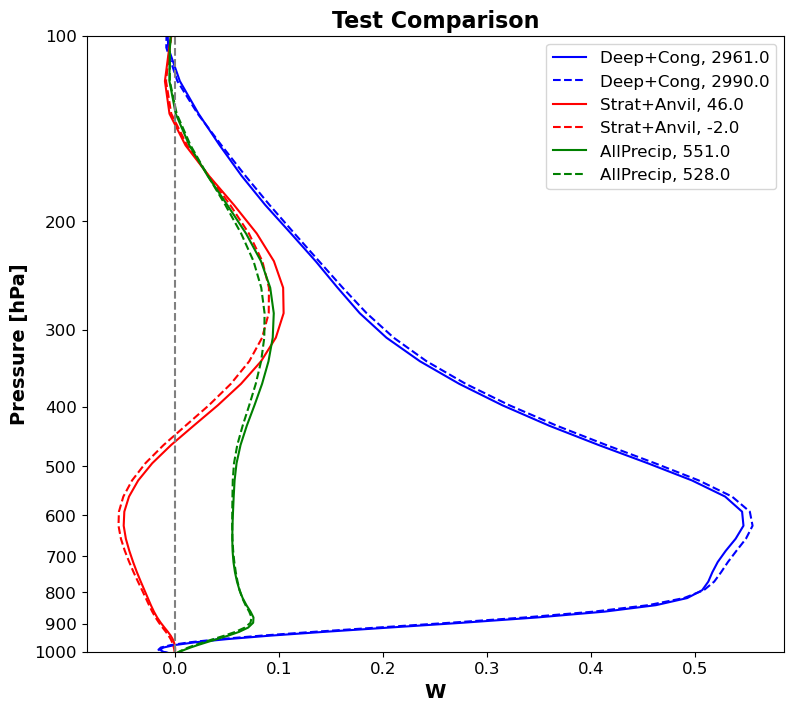

In [118]:
# Vertical motion: test comparison
var1 = np.copy(w)
var2 = np.copy(w2)
xlabel = 'W'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)

#### MSE

In [119]:
iptop = np.where(pres <= 100)[0][0]

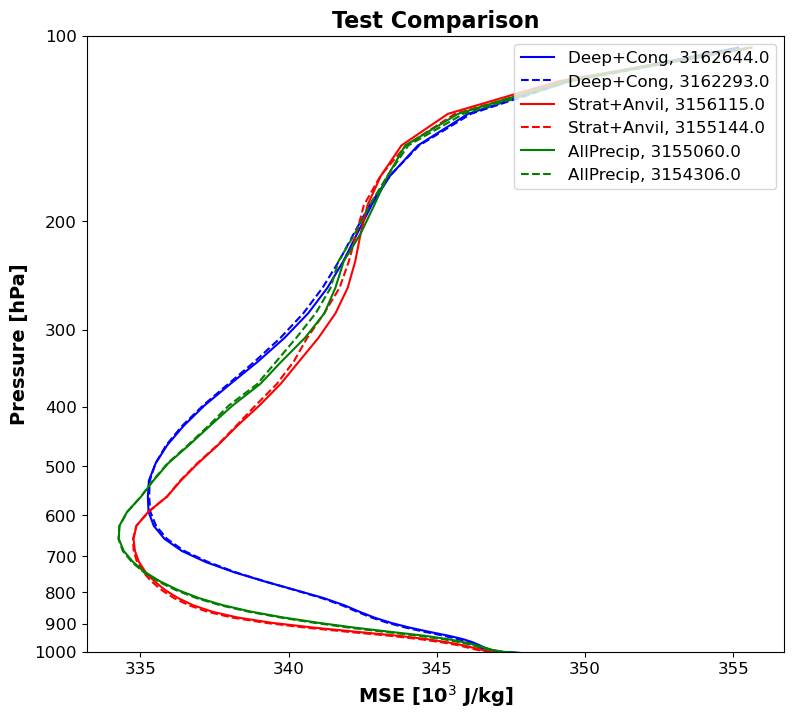

In [120]:
# MSE: test comparison
var1 = np.copy(mse_z[0:iptop])*1e-3
var2 = np.copy(mse_z2[0:iptop])*1e-3
# varm = np.mean(var1)
# varm=340
# var1 -= varm
# var2 -= varm
xlabel = 'MSE [10$^3$ J/kg]'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres[0:iptop], xlabel, zeroline=False)

#### DSE

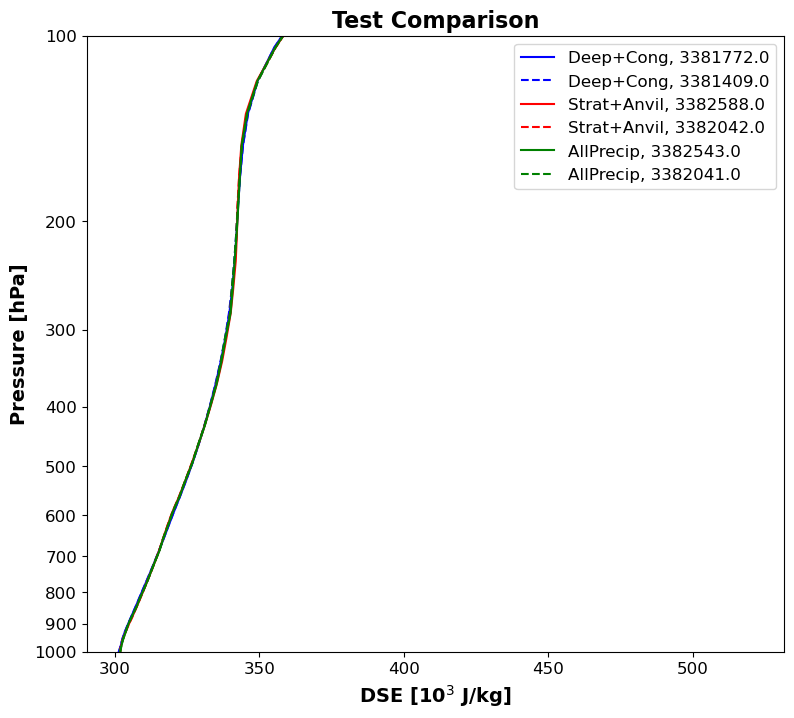

In [121]:
# MSE: test comparison
var1 = np.copy(dse_z)*1e-3
var2 = np.copy(dse_z2)*1e-3
# varm=320
# var1 -= varm
# var2 -= varm
xlabel = 'DSE [10$^3$ J/kg]'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=False)

#### DSE advection

In [122]:
# # Grad_s_adv: test comparison
# dse_avg = var_profiles(dse_z, c_type)
# rho_avg = var_profiles(rho, c_type)
# w_avg = var_profiles(w, c_type)
# dse2_avg = var_profiles(dse_z2, c_type2)
# rho2_avg = var_profiles(rho2, c_type2)
# w2_avg = var_profiles(w2, c_type2)

# precip_list = ['Deep+Cong', 'Strat+Anvil', 'AllPrecip']

# var1 = calc_vadv(w_avg, rho_avg, dse_avg, pres)
# var2 = calc_vadv(w2_avg, rho2_avg, dse2_avg, pres2)
# xlabel = 'DSE VADV'
# plot_prof_compare_tests(var1, var2, precip_list, xlabel, pres, zeroline=True)
# # var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)

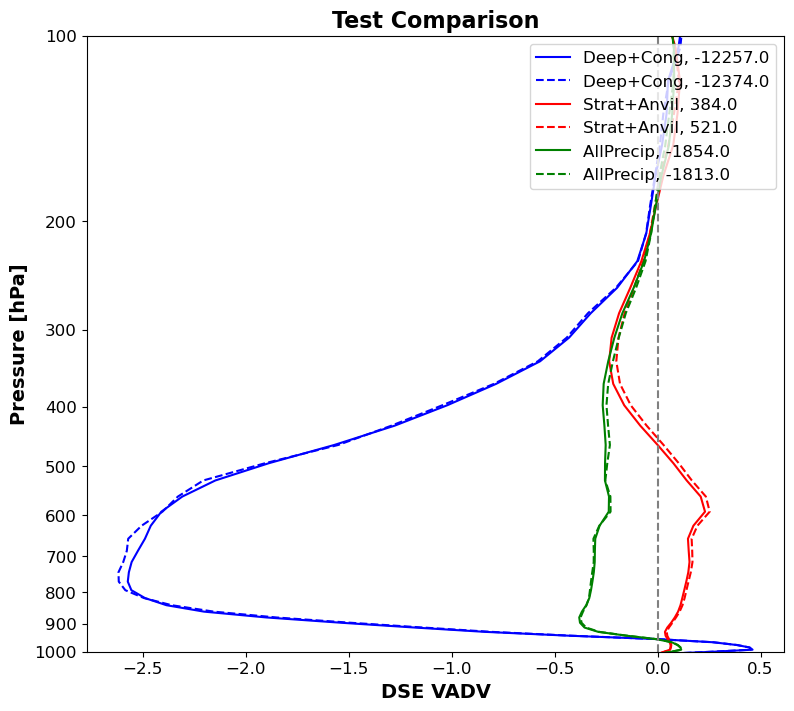

In [123]:
var1 = calc_vadv(w, rho, dse_z, pres)
var2 = calc_vadv(w2, rho2, dse_z2, pres2)
xlabel = 'DSE VADV'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)

#### MSE vertical advection

$Flux = - w \dfrac{\partial \phi}{\partial z}$

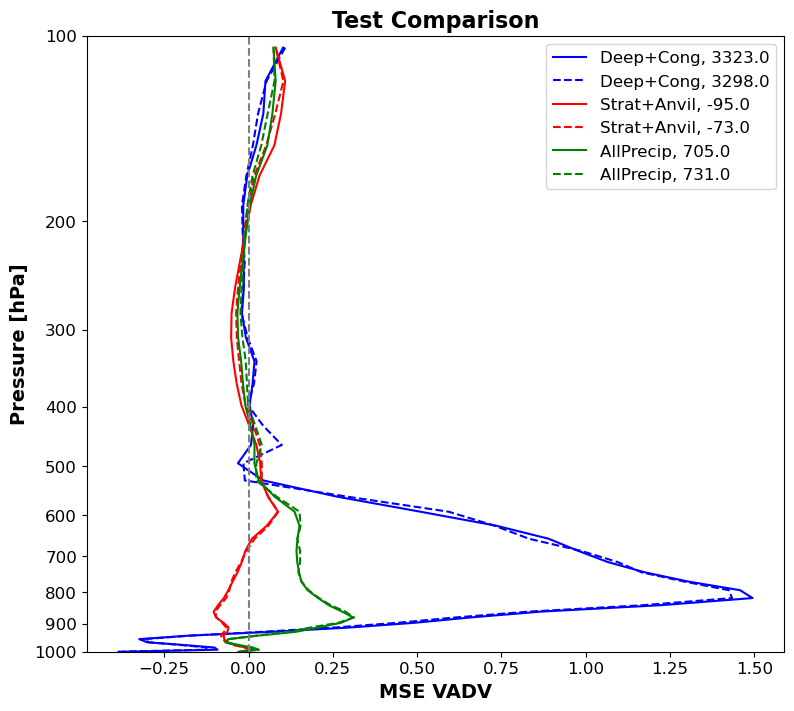

In [124]:
var1 = calc_vadv(w[0:iptop], rho[0:iptop], mse_z[0:iptop], pres[0:iptop])
var2 = calc_vadv(w2[0:iptop], rho2[0:iptop], mse_z2[0:iptop], pres2[0:iptop])
xlabel = 'MSE VADV'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres[0:iptop], xlabel, zeroline=True)

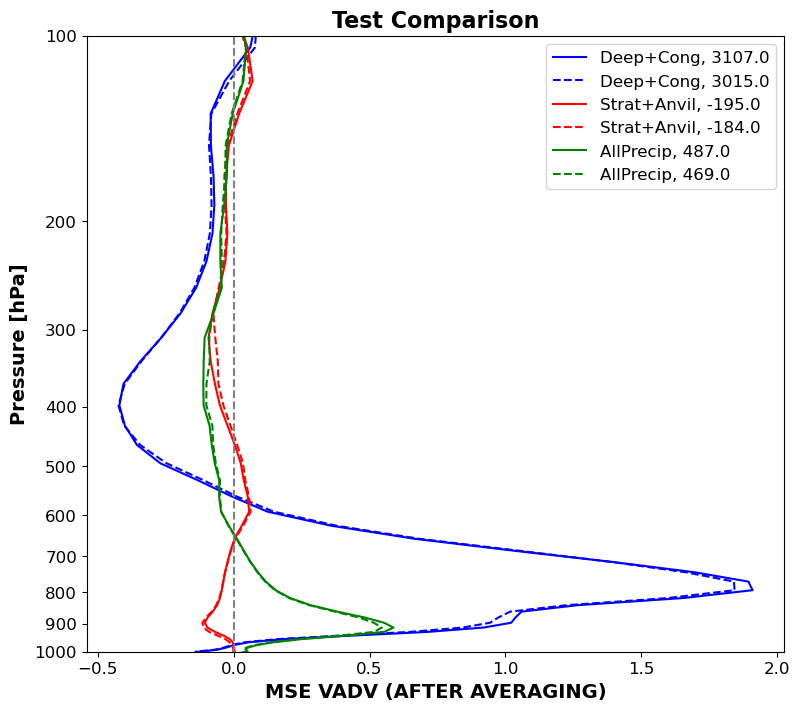

In [125]:
xlabel = 'MSE VADV (AFTER AVERAGING)'
vadv_compare_tests(w, rho, mse_z, c_type, pres,
                   w2, rho2, mse_z2, c_type2, pres2,
                   xlabel, zeroline=True)

____
____

#### MSE horizontal advection

$Flux = - \vec{v} \cdot \nabla \phi$

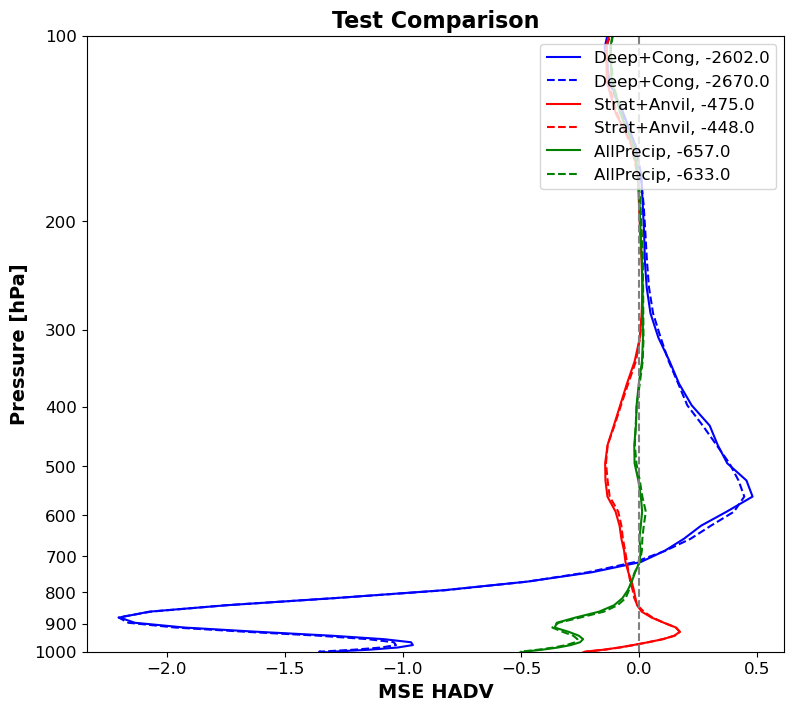

In [126]:
var1 = calc_hadv(u, v, x1d, y1d, mse_z)
var2 = calc_hadv(u2, v2, x1d, y1d, mse_z2)
xlabel = 'MSE HADV'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)

#### MSE TOTAL ADV as

$Flux = -\left( \vec{v} \cdot \nabla \phi + w \dfrac{\partial \phi}{\partial z} \right)$

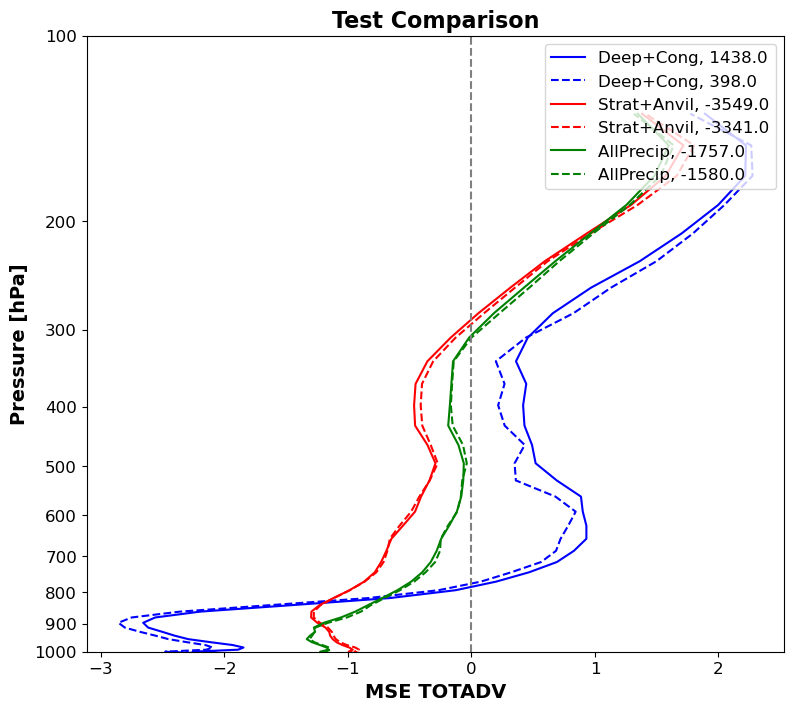

In [127]:
var1 = calc_totadv(u,  v,  w,  rho,  x1d, y1d, pres, np.copy(mse_z))
var2 = calc_totadv(u2, v2, w2, rho2, x1d, y1d, pres2, np.copy(mse_z2))
var1[(pres < 120),:,:] = np.nan
var2[(pres2 < 120),:,:] = np.nan
xlabel = 'MSE TOTADV'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)

#### MSE TOTAL ADV as FLUX:

$Flux = -\nabla \cdot (\phi \vec{v})$

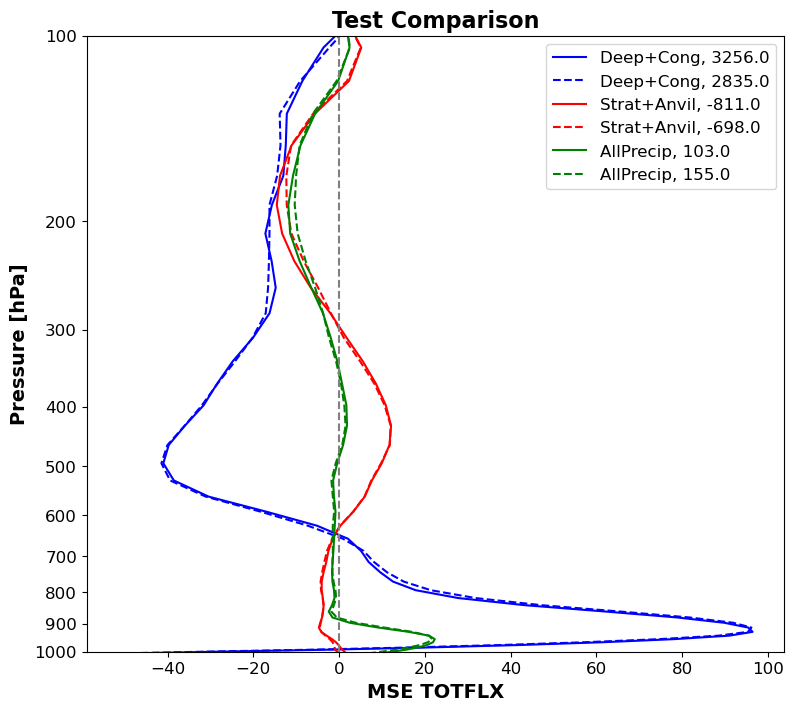

In [128]:
var1 = calc_delflux(u, v, x1d, y1d, np.copy(mse_z))
var2 = calc_delflux(u2, v2, x1d, y1d, np.copy(mse_z2))
xlabel = 'MSE TOTFLX'
var_profiles_compare_tests(var1, var2, c_type, c_type2, pres, xlabel, zeroline=True)